In [1]:
nodes_file = 'data/03_network-nodes.csv'
edges_file = 'data/04_network-edges.csv'

In [54]:
!pip install pandas networkx scipy lxml

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.1/8.1 MB 28.0 MB/s eta 0:00:0000:0100:01


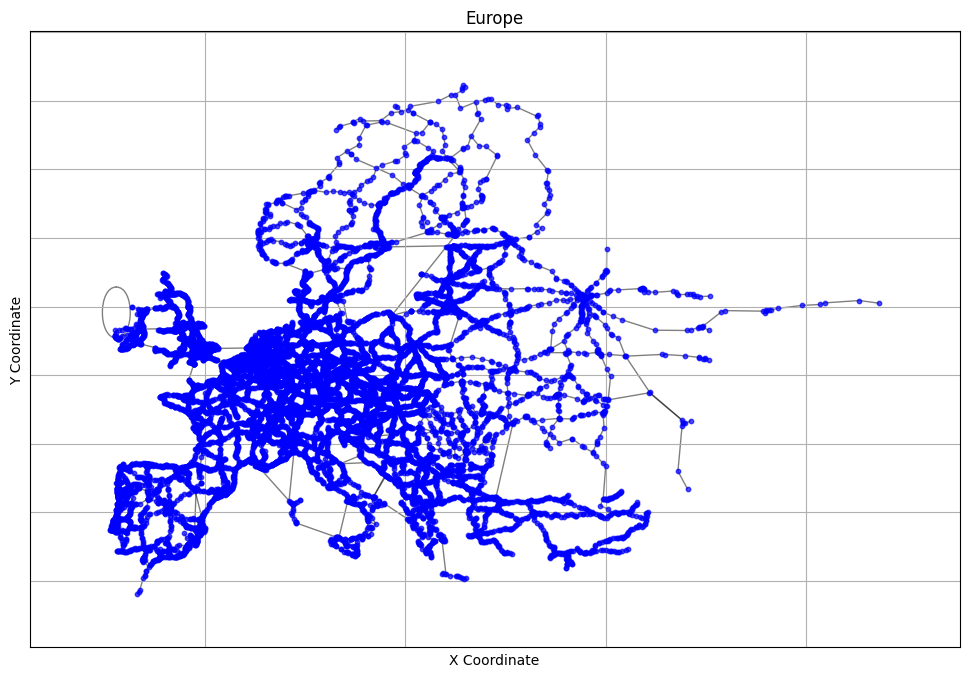

In [36]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt

# 1. Loading the Data
nodes_df = pd.read_csv(nodes_file)
edges_df = pd.read_csv(edges_file)

# Plot the graph
# Create a graph from the edges
G = nx.from_pandas_edgelist(edges_df, 'Network_Node_A_ID', 'Network_Node_B_ID')

# add edge information as attributes to graph
edge_columns = ['Network_Edge_ID', 'Manually_Added', 'Distance', 'Traffic_flow_trucks_2019', 'Traffic_flow_trucks_2030']
for index, row in edges_df.iterrows():
    for column in edge_columns:
        G.edges[row['Network_Node_A_ID'], row['Network_Node_B_ID']][column] = row[column]

# Create a position dictionary from node coordinates
pos = {row['Network_Node_ID']: (row['Network_Node_X'], row['Network_Node_Y']) for index, row in nodes_df.iterrows()}

# Plotting the network
plt.figure(figsize=(12, 8))
nx.draw_networkx_nodes(G, pos, node_size=10, node_color='blue', alpha=0.7)
nx.draw_networkx_edges(G, pos, alpha=0.5)

plt.title('Europe')
plt.xlabel('X Coordinate')
plt.ylabel('Y Coordinate')
plt.grid(True)
plt.show()

In [8]:
nodes_df.head()

,Unnamed: 0,Network_Node_ID,Network_Node_X,Network_Node_Y,ETISplus_Zone_ID,Country
0,0,102872,2.862483,42.695843,112080105,FR
1,1,102340,2.879551,42.729368,112080105,FR
2,2,260340,-0.009172,44.491721,112060104,FR
3,3,102242,0.131516,44.429799,112060104,FR
4,4,101851,2.252316,49.138934,112010008,FR


In [63]:
edges_df.head()

,Unnamed: 0,Network_Edge_ID,Manually_Added,Distance,Network_Node_A_ID,Network_Node_B_ID,Traffic_flow_trucks_2019,Traffic_flow_trucks_2030
0,0,2604457,0,5.980,262914,260432,0,0
1,1,1013364,0,18.559,262914,109845,0,0
2,2,2604243,0,2.012,262911,109968,1871252,2513351
3,3,1013595,0,4.728,262911,122766,1871252,2513351
4,4,2604354,0,15.028,262909,260001,1038691,1449368


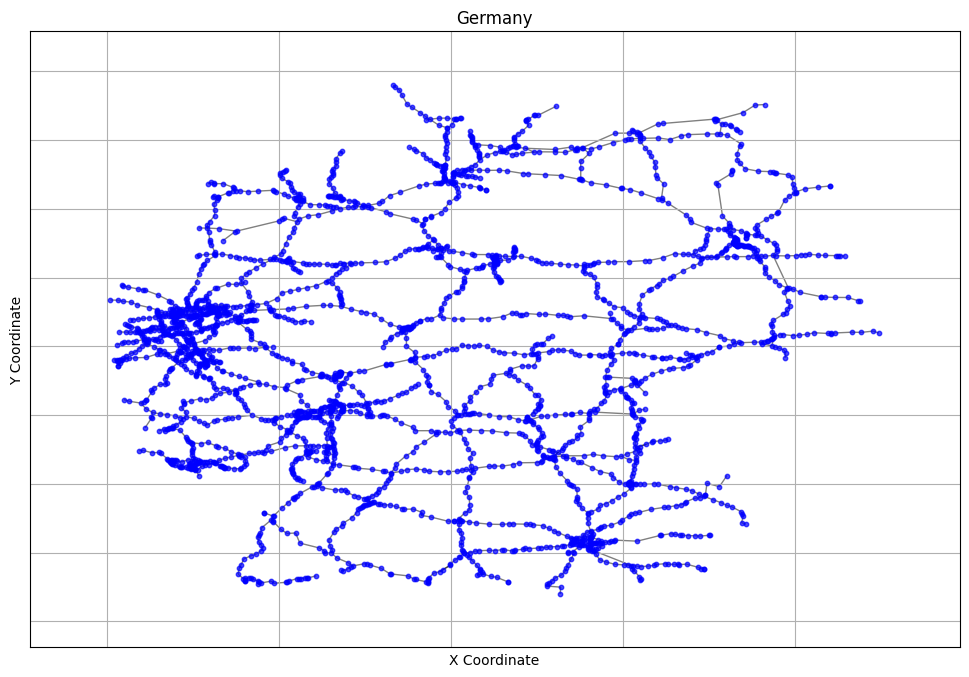

In [48]:

# 2. Filtering for a Specific Country (Germany)
german_nodes = nodes_df[nodes_df['Country'] == 'DE']
german_edges = edges_df[edges_df['Network_Node_A_ID'].isin(german_nodes['Network_Node_ID']) & 
                        edges_df['Network_Node_B_ID'].isin(german_nodes['Network_Node_ID'])]


# Create a graph from the German edges
G_germany = nx.from_pandas_edgelist(german_edges, 'Network_Node_A_ID', 'Network_Node_B_ID')

# add edge information as attributes to graph
edge_columns = ['Network_Edge_ID', 'Manually_Added', 'Distance', 'Traffic_flow_trucks_2019', 'Traffic_flow_trucks_2030']
for index, row in german_edges.iterrows():
    for column in edge_columns:
        G_germany.edges[row['Network_Node_A_ID'], row['Network_Node_B_ID']][column] = row[column]

# Create a position dictionary from node coordinates
pos_germany = {row['Network_Node_ID']: (row['Network_Node_X'], row['Network_Node_Y']) for index, row in german_nodes.iterrows()}
# Plotting the network
plt.figure(figsize=(12, 8))
nx.draw_networkx_nodes(G_germany, pos_germany, node_size=10, node_color='blue', alpha=0.7)
nx.draw_networkx_edges(G_germany, pos_germany, alpha=0.5)

plt.title('Germany')
plt.xlabel('X Coordinate')
plt.ylabel('Y Coordinate')
plt.grid(True)
plt.show()



In [71]:
import yaml

# 3. Iterative Reduction of Nodes
def remove_nodes_and_merge_edges(graph):    
    for edge in graph.edges():
        graph.edges[edge]['original'] = True
        graph.edges[edge]['node_ids'] = []
        graph.edges[edge]['edge_ids'] = []

    # check that all edges have the original attribute
    assert all([graph.edges[edge]['original'] for edge in graph.edges()])


    while True:
        nodes_with_two_edges = [node for node, degree in dict(graph.degree()).items() if degree == 2]
        if not nodes_with_two_edges:
            break

        for node in nodes_with_two_edges:
            neighbors = list(graph.neighbors(node))
            if len(neighbors) == 2:
                edge_1 = graph.edges[node, neighbors[0]]
                edge_2 = graph.edges[node, neighbors[1]]

                nodes = [node]
                if not edge_1['original']:
                    nodes += edge_1['node_ids']
                if not edge_2['original']:
                    nodes += edge_2['node_ids']	
                
                edges = []
                if not edge_1['original']:
                    edges += edge_1['edge_ids']
                else:
                    edges += [int(edge_1["Network_Edge_ID"])]

                if not edge_2['original']:
                    edges += edge_2['edge_ids']
                else:
                    edges += [int(edge_2["Network_Edge_ID"])]
                
                graph.remove_node(node)

                if not graph.has_edge(neighbors[0], neighbors[1]):
                    graph.add_edge(neighbors[0], neighbors[1])
                    graph.edges[neighbors[0], neighbors[1]]['Distance'] = float(edge_1['Distance'] + edge_2['Distance']))
                    graph.edges[neighbors[0], neighbors[1]]['node_ids'] = nodes
                    graph.edges[neighbors[0], neighbors[1]]['edge_ids'] = edges
                    graph.edges[neighbors[0], neighbors[1]]['original'] = False
                else:
                    # edge already exists, leave the closer one
                    edge_3 = graph.edges[neighbors[0], neighbors[1]]
                    if edge_1['Distance'] + edge_2['Distance'] < edge_3['Distance']:
                        graph.edges[neighbors[0], neighbors[1]]['Distance'] = edge_1['Distance'] + edge_2['Distance']
                        graph.edges[neighbors[0], neighbors[1]]['node_ids'] = nodes
                        graph.edges[neighbors[0], neighbors[1]]['edge_ids'] = edges
                        graph.edges[neighbors[0], neighbors[1]]['original'] = False

    new_edge_info = []
    id = 5_000_000# Highest id in dataset 2616216   
    for edge in graph.edges():
        if not graph.edges[edge]['original']:
            graph.edges[edge]['Network_Edge_ID'] = id
            new_edge_info.append(graph.edges[edge].copy())
            id += 1
        del graph.edges[edge]['node_ids']
        del graph.edges[edge]['edge_ids']

    return graph, new_edge_info

G_germany_reduced, new_edge_info = remove_nodes_and_merge_edges(G_germany.copy())

# 4. Store the Results
nx.write_graphml_lxml(G_germany_reduced, 'data/graph-germany-reduced.graphml')

# store new edge information as yaml
# make sure that the types are not numpy types
import numpy as np
for edge in new_edge_info:
    for key, value in edge.items():
        if key == 'edge_ids':
            edge


        if isinstance(value, np.int64):
            edge[key] = int(value)
        elif isinstance(value, np.float64):
            edge[key] = float(value)
        elif isinstance(value, np.ndarray):
            edge[key] = value.tolist()
        elif isinstance(value, list):
            for i, item in enumerate(value):
                if isinstance(item, np.int64):
                    value[i] = int(item)
                elif isinstance(item, np.float64):
                    value[i] = float(item)
                elif isinstance(item, np.ndarray):
                    value[i] = item.tolist()


with open('data/05_network-edges-reduced.yaml', 'w') as file:
    yaml.dump(new_edge_info, file)
    

In [61]:
# test loadin new edge info
new_edge_info_df = pd.read_csv('data/network-new-edges-reduced.csv')
new_edge_info_df.head()

type(new_edge_info_df['node_ids'][0])

str